<div style="border: 2px solid blue; padding: 5px; color: red; text-align: center; font-size: 24px;">
 Self-attention  vs Multi-head Attention
</div>

Le but de ce notebook est de comparer des embeddings calculés avec des couches de self-attention et multi-head attention sur une tâche de classification.



# Librairies

In [1]:
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd
import torch
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from transformers import BertTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set_style('darkgrid')

c:\Users\mbial\miniconda3\envs\nkobo\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


In [2]:
batch_size = 32

# Data

Nous allons utiliser un jeu de données disponible.

In [3]:
from datasets import load_dataset

emotions = load_dataset("emotion")
emotions

c:\Users\mbial\miniconda3\envs\nkobo\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mbial\.cache\huggingface\hub\datasets--emotion. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 399457.52 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [46]:
emotions['train'][10]

{'text': 'i feel like i have to make the suffering i m seeing mean something',
 'label': 0}

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

c:\Users\mbial\miniconda3\envs\nkobo\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mbial\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [48]:
text = emotions['train'][1]['text']

In [55]:
tokens = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=30,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

In [56]:
tokens.keys()

dict_keys(['input_ids', 'attention_mask'])

In [57]:
tokens

{'input_ids': tensor([[  101,  1045,  2064,  2175,  2013,  3110,  2061, 20625,  2000,  2061,
          9636, 17772,  2074,  2013,  2108,  2105,  2619,  2040, 14977,  1998,
          2003,  8300,   102,     0,     0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0]])}

In [58]:
token_ids = tokens["input_ids"][0]
token_list = tokenizer.convert_ids_to_tokens(token_ids)
token_list

['[CLS]',
 'i',
 'can',
 'go',
 'from',
 'feeling',
 'so',
 'hopeless',
 'to',
 'so',
 'damned',
 'hopeful',
 'just',
 'from',
 'being',
 'around',
 'someone',
 'who',
 'cares',
 'and',
 'is',
 'awake',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [7]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create dataset and dataloader
train_dataset = TextDataset(emotions["train"]["text"], emotions["train"]["label"], tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataset = TextDataset(emotions["validation"]["text"], emotions["validation"]["label"], tokenizer)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TextDataset(emotions["test"]["text"], emotions["test"]["label"], tokenizer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [59]:
for i in train_loader:
    #print(i)
    break

In [67]:
train_dataset[5]

{'text': 'ive been feeling a little burdened lately wasnt sure why that was',
 'input_ids': tensor([  101,  4921,  2063,  2042,  3110,  1037,  2210, 10859,  2098,  9906,
          2347,  2102,  2469,  2339,  2008,  2001,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,    

In [65]:
i['input_ids']

tensor([[  101,  1045,  2514,  ...,     0,     0,     0],
        [  101,  1045,  2941,  ...,     0,     0,     0],
        [  101,  1045,  2106,  ...,     0,     0,     0],
        ...,
        [  101,  1045,  2514,  ...,     0,     0,     0],
        [  101, 10047,  2074,  ...,     0,     0,     0],
        [  101,  1045,  2001,  ...,     0,     0,     0]])

# Modèles


Pour le self-attention, nous implémentons les étapes suivantes:
1. Les poids d'attention sont donnés par: $\hat{a} = q * k_i$, puis ils ont normalisés avec le softmax : $a_i =\frac{e^{\hat{a}_{i}}}{\sum_{j}{e^{\hat{a}_{j}}}} $
2. La sortie (output z) $z$ est le produit entre les poids d'attention $a_{1:N}$ et les valeurs $V_{1:N}$
    $$ {\color{blue} z = } \sum_{i}{\hat{a}_i*{\color{red}v_i}} = \hat{a}*{\color{red}v}$$
3. k , v sont calculés à partir de l'input x :
    $${\color{green}k} = {\color{green}W_k}*{\color{blue}x}$$
    $${\color{green}v} = {\color{green}W_v}*{\color{blue}x}$$
4. Les queries : $${\color{green}q} = {\color{green}W_q}*{\color{blue}x}$$

In [16]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x, attention_mask):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        attention_scores = torch.bmm(Q, K.transpose(1, 2)) / (self.embed_size ** 0.5)
        attention_mask = attention_mask.unsqueeze(1).unsqueeze(2).to(dtype=attention_scores.dtype)
        attention_scores = attention_scores.masked_fill(attention_mask == 0, float('-inf'))
        attention = self.softmax(attention_scores)
        out = torch.bmm(attention, V)
        return out

In [68]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads

        assert self.head_dim * num_heads == embed_size, "Embedding size must be divisible by num_heads"

        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)
        self.softmax = nn.Softmax(dim=3)

    def forward(self, x, attention_mask):
        N = x.shape[0]
        Q = self.query(x).view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(x).view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(x).view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)
        attention_scores = torch.matmul(Q, K.transpose(2, 3)) / (self.head_dim ** 0.5)
        # attention_scores = attention_scores.masked_fill(attention_mask == 0, float('-inf'))
        attention = self.softmax(attention_scores)
        out = torch.matmul(attention, V).transpose(1, 2).contiguous().view(N, -1, self.embed_size)
        out = self.fc_out(out)
        return out

Nous allons entrainer un text classifier avec un réseau à trois couches:
1. Une couche d'embedding
2. Une couche d'attention (self-attention ou multi-head attention)
3. Une couche linéaire

In [69]:
class SelfAttentionModel(nn.Module):
    def __init__(self, vocab_size, embed_size, n_labels):
        super(SelfAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = SelfAttention(embed_size)
        self.fc = nn.Linear(embed_size, n_labels)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x = self.attention(x, attention_mask)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

class MultiHeadAttentionModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, n_labels):
        super(MultiHeadAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = MultiHeadAttention(embed_size, num_heads)
        self.fc = nn.Linear(embed_size, n_labels)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x = self.attention(x, attention_mask)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

In [19]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path='best_model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self,  model):
        '''Saves model when validation loss decreases.'''
        torch.save(model.state_dict(), self.path)

In [25]:
def train_model(model, train_loader, val_loader, epochs=5, patience=5, min_delta=10e-4, path='best_model.pth'):
    print("Training model for {} epochs".format(epochs))
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta, path=path)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    all_losses = []
    valid_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            # Convert texts to tensor of token indices
            outputs = model(data['input_ids'], data['attention_mask'])
            loss = criterion(outputs, data['label'])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        all_losses.append(train_loss/len(train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                outputs = model(data['input_ids'], data['attention_mask'])
                loss = criterion(outputs, data['label'])
                val_loss += loss.item()
        valid_losses.append(val_loss/len(val_loader))
        early_stopping(val_loss, model)
        print(f"Epoch {epoch+1}, Validation Loss: {val_loss/len(val_loader)}, Train loss: {train_loss/len(train_loader)}")
    return all_losses, valid_losses

In [70]:
# Initialisons les modèles
n_labels = len(np.unique(emotions['train']['label']))
vocab_size = tokenizer.vocab_size
embed_size = 128
num_heads = 8
epochs = 100
self_attention_model = SelfAttentionModel(vocab_size, embed_size, n_labels=n_labels)
multi_head_attention_model = MultiHeadAttentionModel(vocab_size, embed_size, num_heads, n_labels=n_labels)


In [29]:
print("Training Self-Attention Model")
train_loss_self_attention, valid_loss_self_attention = train_model(self_attention_model, train_loader, valid_loader, epochs=epochs,path='best_self_attention_model.pth')



Training Self-Attention Model
Training model for 100 epochs
Epoch 1, Validation Loss: 1.5754394266340468, Train loss: 1.5820045068264008
Epoch 2, Validation Loss: 1.5578655610008845, Train loss: 1.564535591363907
Epoch 3, Validation Loss: 1.5221220198131742, Train loss: 1.5346463897228242
Epoch 4, Validation Loss: 1.475882575625465, Train loss: 1.4855394079685211
Epoch 5, Validation Loss: 1.409206920199924, Train loss: 1.4158441541194915
Epoch 6, Validation Loss: 1.3309764275475153, Train loss: 1.3321572434902191
Epoch 7, Validation Loss: 1.2630010171542092, Train loss: 1.240715897321701
Epoch 8, Validation Loss: 1.1755788723627727, Train loss: 1.1469543467760086
Epoch 9, Validation Loss: 1.094023839821891, Train loss: 1.0522357053756715
Epoch 10, Validation Loss: 1.0215971999698215, Train loss: 0.9599604976177215
Epoch 11, Validation Loss: 0.9481589680626279, Train loss: 0.8699878383874893
Epoch 12, Validation Loss: 0.8816413245503865, Train loss: 0.7836693702340126
Epoch 13, Validati

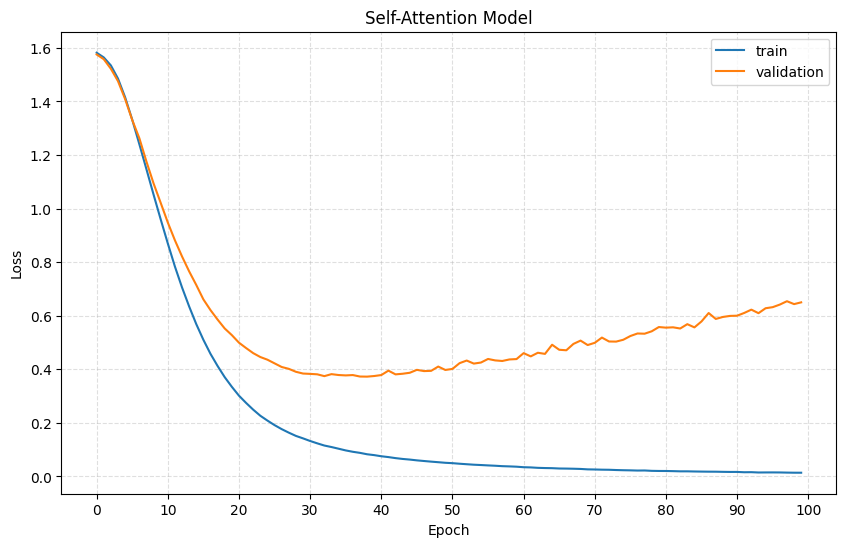

In [33]:
plt.figure(figsize=(10, 6))
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
sns.lineplot(x=range(epochs), y=train_loss_self_attention, label='train')
sns.lineplot(x=range(epochs), y=valid_loss_self_attention, label='validation')
# set xaixs with only epochs values
plt.xticks(np.arange(0, epochs +1, 10) )
plt.xlabel('Epoch')
plt.ylabel('Loss', )
plt.title('Self-Attention Model')
plt.show()

In [34]:
print("Training Multi-Head Attention Model")
train_loss_multi_head, valid_loss_multi_head = train_model(multi_head_attention_model, train_loader, valid_loader, epochs=epochs,path='best_multihead_attention_model.pth')

Training Multi-Head Attention Model
Training model for 100 epochs
Epoch 1, Validation Loss: 0.7073594099945493, Train loss: 1.2331166557073594
Epoch 2, Validation Loss: 0.4717088653927758, Train loss: 0.5220813668072224
Epoch 3, Validation Loss: 0.4278984343012174, Train loss: 0.31357268857955933
Epoch 4, Validation Loss: 0.4479924128169105, Train loss: 0.2136433791704476
Epoch 5, Validation Loss: 0.4725015838113096, Train loss: 0.15911791138350964
Epoch 6, Validation Loss: 0.5261543841352538, Train loss: 0.12071474605426193
Epoch 7, Validation Loss: 0.5865654691699005, Train loss: 0.09416053939517588
Epoch 8, Validation Loss: 0.6750400770041678, Train loss: 0.06965801326208748
Epoch 9, Validation Loss: 0.7103780912501472, Train loss: 0.06529725126898847
Epoch 10, Validation Loss: 0.7330300779569716, Train loss: 0.06192266616923735
Epoch 11, Validation Loss: 0.7213365977541322, Train loss: 0.047778200776316226
Epoch 12, Validation Loss: 0.751951459736105, Train loss: 0.0458524038656032

Text(0.5, 1.0, 'Multi head Attention Model')

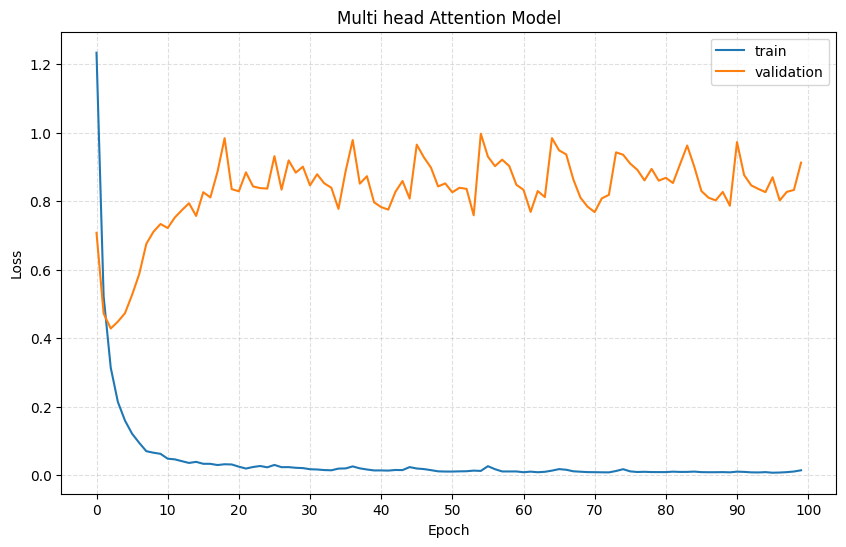

In [35]:
plt.figure(figsize=(10, 6))
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
sns.lineplot(x=range(epochs), y=train_loss_multi_head, label='train')
sns.lineplot(x=range(epochs), y=valid_loss_multi_head, label='validation')
# set xaixs with only epochs values
plt.xticks(np.arange(0, epochs+1, 10))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Multi head Attention Model')

# Evaluation and Explicabilité

In [36]:
self_attention_model.load_state_dict(torch.load('best_self_attention_model.pth'))
multi_head_attention_model.load_state_dict(torch.load('best_multihead_attention_model.pth'))

C:\Users\mbial\AppData\Local\Temp\ipykernel_8948\4104137105.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self_attention_model.load_state_dict(torch.load('best_self_at

<All keys matched successfully>

In [37]:

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels, title):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title(f"Normalized confusion matrix for {title} model")
    plt.show()

def compute_pred(model, data):
    model.eval()
    preds = []
    true = []
    with torch.no_grad():
        for data in data:
            outputs = model(data['input_ids'], data['attention_mask'])
            preds.extend(outputs.argmax(dim=1).tolist())
            true.extend(data['label'].tolist())
    return preds, true
    

In [38]:
labels = emotions["train"].features["label"].names

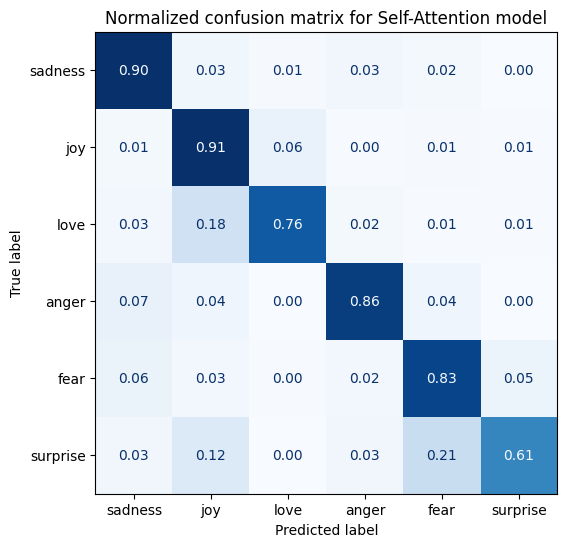

In [39]:
preds_self, true_self = compute_pred(self_attention_model, test_loader)
plot_confusion_matrix(preds_self, true_self, labels, "Self-Attention")

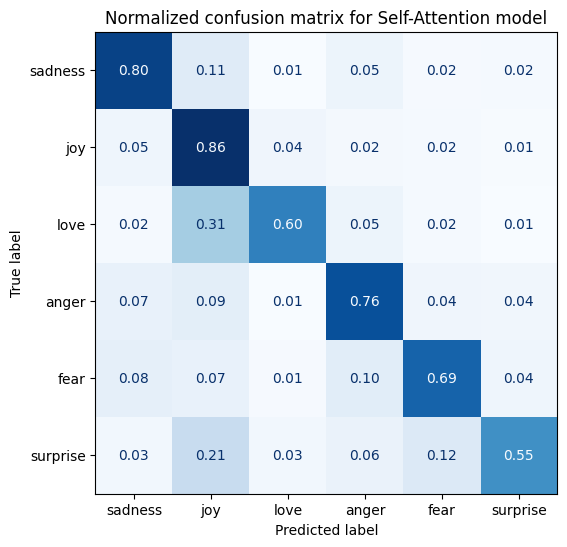

In [122]:
preds_self, true_self = compute_pred(self_attention_model, test_loader)
plot_confusion_matrix(preds_self, true_self, labels, "Self-Attention")

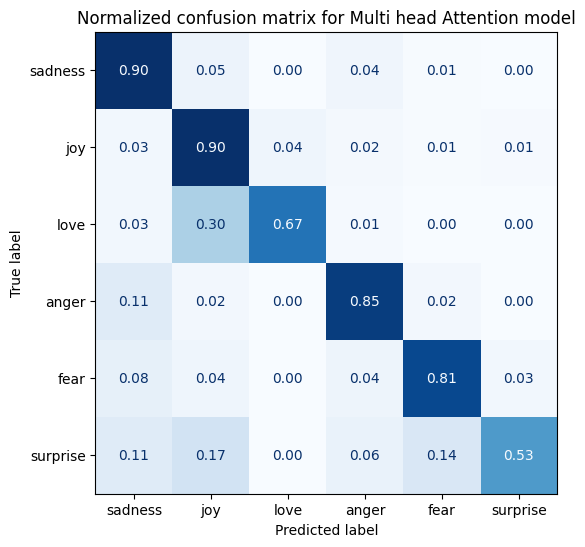

In [40]:
preds, true = compute_pred(multi_head_attention_model, test_loader)
plot_confusion_matrix(preds, true, labels, "Multi head Attention")

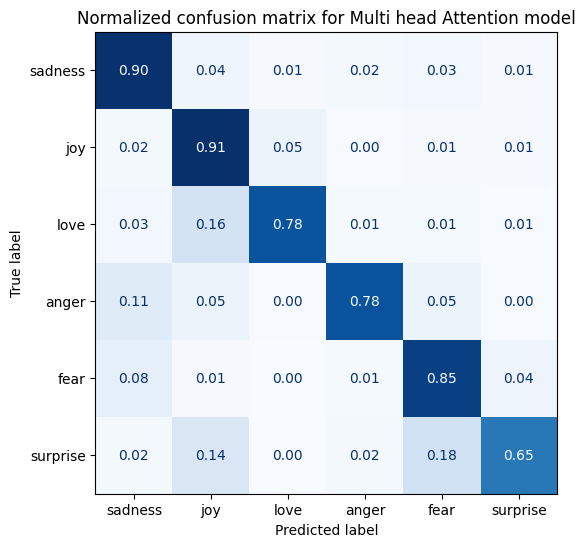

In [123]:
preds, true = compute_pred(multi_head_attention_model, test_loader)
plot_confusion_matrix(preds, true, labels, "Multi head Attention")

In [41]:
self_cf = classification_report(true_self, preds_self, target_names=labels, output_dict=True)
self_cf = pd.DataFrame(self_cf).T
self_cf

,precision,recall,f1-score,support
sadness,0.916084,0.901893,0.908933,581.000
joy,0.897436,0.906475,0.901933,695.000
love,0.707602,0.761006,0.733333,159.000
anger,0.883895,0.858182,0.870849,275.000
fear,0.816594,0.834821,0.825607,224.000
surprise,0.677966,0.606061,0.640000,66.000
accuracy,0.869000,0.869000,0.869000,0.869
macro avg,0.816596,0.811406,0.813443,2000.000
weighted avg,0.869603,0.869000,0.869096,2000.000


In [42]:
mh_cf = classification_report(true, preds, target_names=labels, output_dict=True)
mh_cf = pd.DataFrame(mh_cf).T
mh_cf

,precision,recall,f1-score,support
sadness,0.872910,0.898451,0.885496,581.000
joy,0.858516,0.899281,0.878426,695.000
love,0.785185,0.666667,0.721088,159.000
anger,0.818182,0.850909,0.834225,275.000
fear,0.887805,0.812500,0.848485,224.000
surprise,0.729167,0.530303,0.614035,66.000
accuracy,0.852000,0.852000,0.852000,0.852
macro avg,0.825294,0.776352,0.796959,2000.000
weighted avg,0.850334,0.852000,0.849816,2000.000


C:\Users\mbial\AppData\Local\Temp\ipykernel_8948\2394597230.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (self_cf["precision"].iloc[:6][i], mh_cf["precision"].iloc[:6][i]))


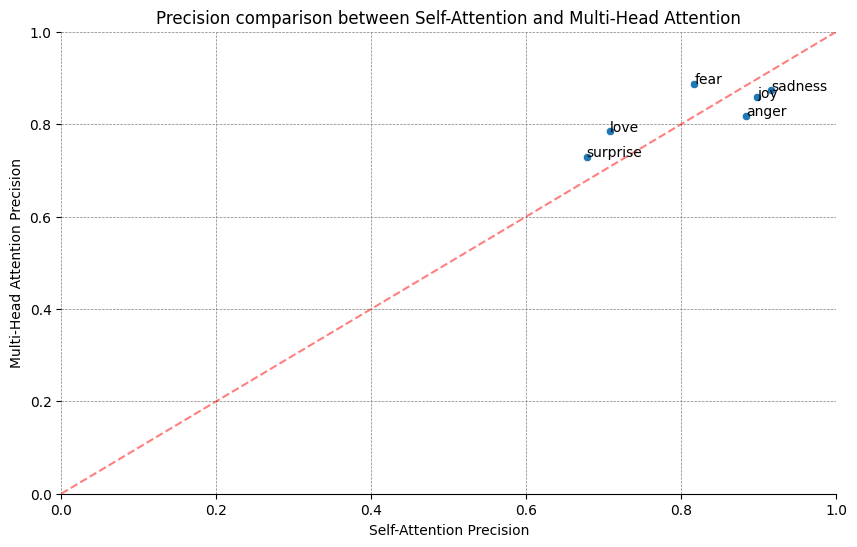

In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=self_cf.iloc[:6]["precision"], y=mh_cf.iloc[:6]["precision"])
# add index name as label in the plot
for i, txt in enumerate(labels):
    plt.annotate(txt, (self_cf["precision"].iloc[:6][i], mh_cf["precision"].iloc[:6][i]))
# add the diagonal line
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls="--", c="red", alpha=0.5)
# removre superior line
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Self-Attention Precision")
plt.ylabel("Multi-Head Attention Precision")
plt.title("Precision comparison between Self-Attention and Multi-Head Attention")
# add dark grid mode
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

/var/folders/6d/dll_cr11353f0zcrbycxldth0000gn/T/ipykernel_3516/2394597230.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (self_cf["precision"].iloc[:6][i], mh_cf["precision"].iloc[:6][i]))


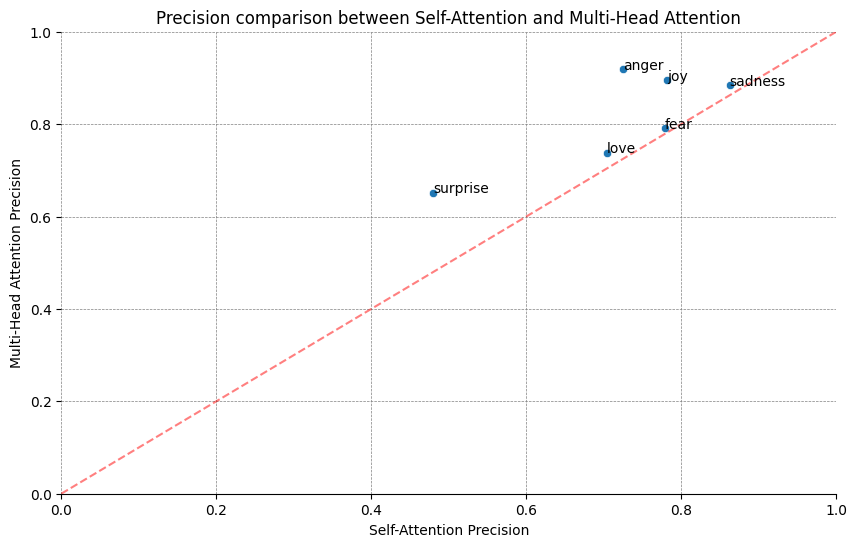

In [128]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=self_cf.iloc[:6]["precision"], y=mh_cf.iloc[:6]["precision"])
# add index name as label in the plot
for i, txt in enumerate(labels):
    plt.annotate(txt, (self_cf["precision"].iloc[:6][i], mh_cf["precision"].iloc[:6][i]))
# add the diagonal line
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls="--", c="red", alpha=0.5)
# removre superior line
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Self-Attention Precision")
plt.ylabel("Multi-Head Attention Precision")
plt.title("Precision comparison between Self-Attention and Multi-Head Attention")
# add dark grid mode
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

C:\Users\mbial\AppData\Local\Temp\ipykernel_8948\2503425273.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (self_cf["recall"].iloc[:6][i], mh_cf["recall"].iloc[:6][i]))


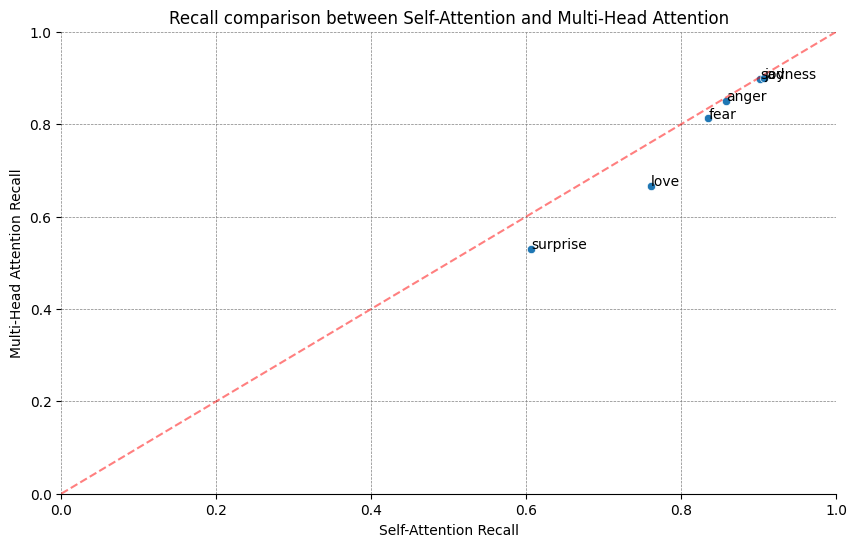

In [44]:
plt.figure(figsize=(10, 6))
plt.xlim(0, 1)
plt.ylim(0, 1)
sns.scatterplot(x=self_cf.iloc[:6]["recall"], y=mh_cf.iloc[:6]["recall"])
# add index name as label in the plot
for i, txt in enumerate(labels):
    plt.annotate(txt, (self_cf["recall"].iloc[:6][i], mh_cf["recall"].iloc[:6][i]))
# add the diagonal line
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls="--", c="red", alpha=0.5)
# removre superior line
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
#set all axis min to 0 and max to 1

plt.xlabel("Self-Attention Recall")
plt.ylabel("Multi-Head Attention Recall")
plt.title("Recall comparison between Self-Attention and Multi-Head Attention")
# add dark grid mode
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

C:\Users\mbial\AppData\Local\Temp\ipykernel_8948\3167453432.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (self_cf["f1-score"].iloc[:6][i], mh_cf["f1-score"].iloc[:6][i]))


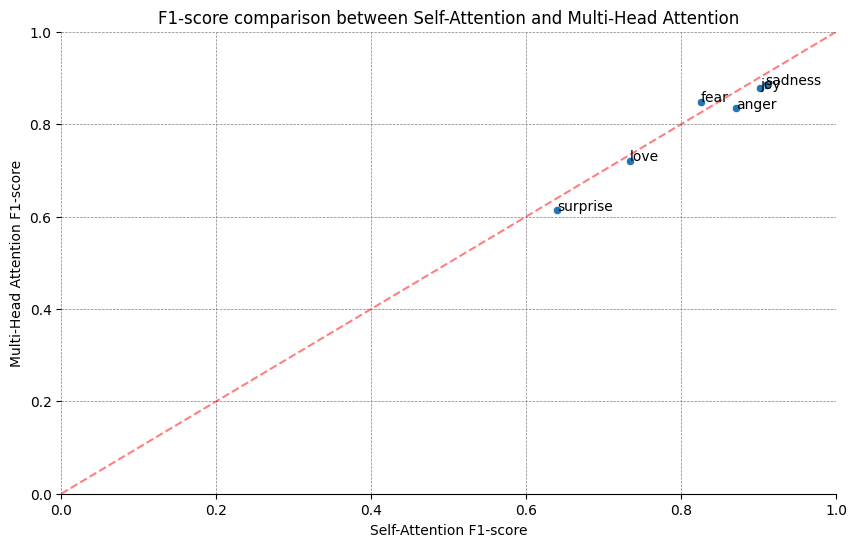

In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=self_cf.iloc[:6]["f1-score"], y=mh_cf.iloc[:6]["f1-score"])
plt.xlim(0, 1)
plt.ylim(0, 1)
# add index name as label in the plot
for i, txt in enumerate(labels):
    plt.annotate(txt, (self_cf["f1-score"].iloc[:6][i], mh_cf["f1-score"].iloc[:6][i]))
# add the diagonal line
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls="--", c="red", alpha=0.5)
# removre superior line
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.xlabel("Self-Attention F1-score")
plt.ylabel("Multi-Head Attention F1-score")
plt.title("F1-score comparison between Self-Attention and Multi-Head Attention")
# add dark grid mode
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

1. Le modèle avec plusieurs tête d'attention a un meilleure score de F1.
2. le modèle Multi-Head a convergé rapidement par rapport au self-attention.